In [1]:
import sys
from pathlib import Path

path_root = Path( '/project_ghent/HADSP/reservoirpy/')
sys.path.append(str(path_root))
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse
from tqdm import tqdm

import reservoirpy
reservoirpy.verbosity(0)

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

In [3]:
from importlib import reload

# Utility functions
from reservoir.utility import show_matrice

# SEED
SEED = 49387

# Reservoir functions

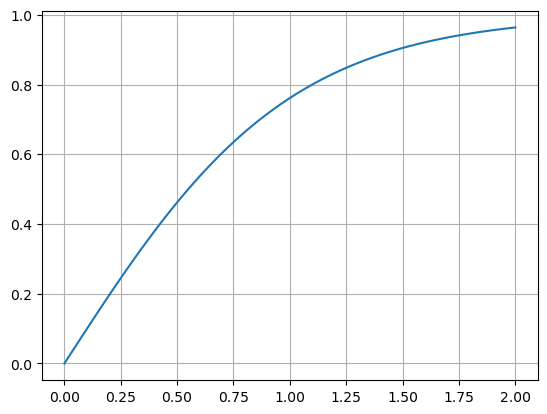

In [4]:
from reservoir.reservoir import update_reservoir, ridge_regression, train, run
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

# Datasets

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Mackey-Glass

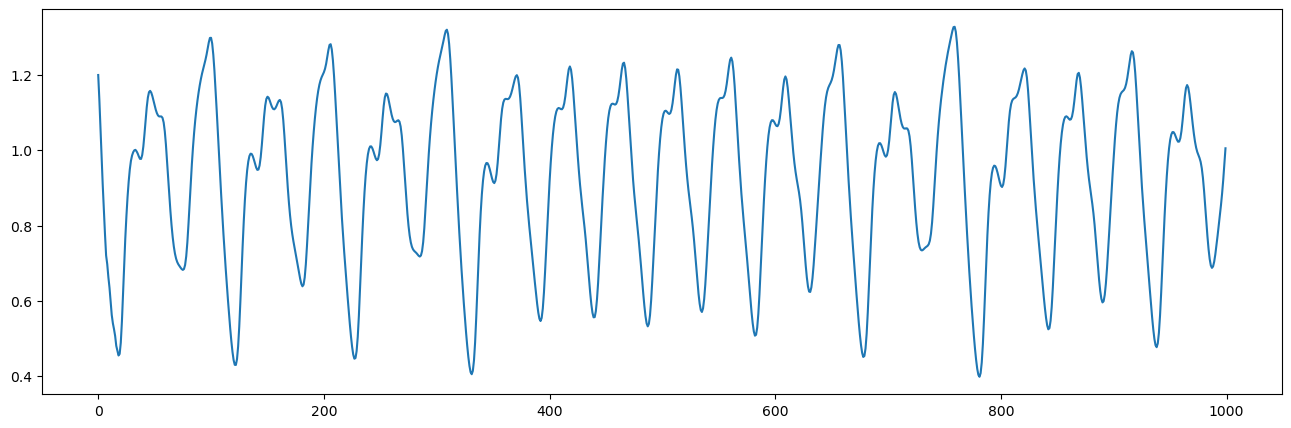

In [5]:
from reservoirpy.datasets import mackey_glass

timesteps = 10000
mg_inputs = mackey_glass(timesteps, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1, seed=None)

# Define the time step of your Mackey-Glass system
dt = 0.00001

# Compute the equivalent sampling rate
sampling_rate = 1 / dt

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(1000), mg_inputs[:1000])
plt.show()

## Japanese voyels

In [6]:
from reservoirpy.datasets import japanese_vowels

X_train, Y_train, X_test, Y_test = japanese_vowels()

In [7]:
X_pretrain = np.concatenate(X_train, axis=0)
X_pretrain.shape
filtered_data = X_pretrain.T

## InsectWingbeat

## MELD

https://github.com/declare-lab/MELD


## Free Spoken Digits Dataset

In [8]:
from datasets.load_datasets import load_FSDD_dataset

data_dir = 'datasets/fsdd/free-spoken-digit-dataset-master/recordings'  # Path to the extracted dataset
sampling_rate, X_train, X_test, Y_train, Y_test = load_FSDD_dataset(data_dir, seed=SEED)
# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

2023-07-29 20:01:09.484777: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-29 20:01:09.549409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 20:01:10.621920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of audio files: 3000


  0%|          | 0/3000 [00:00<?, ?it/s]2023-07-29 20:01:12.183775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3000]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 3000/3000 [00:00<00:00, 3809.95it/s]


Mean sampling rate: 8000.0
X_train shape: (1500,)
Y_train shape: (1500, 10)
X_test shape: (1500,)
Y_test shape: (1500, 10)


# New inputs creation with band filters

Spectrograms_vs_Cochleagrams : 
* https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

## Pretrain dataset

In [9]:
#take a long time (15min with half the samples, instant with 20 which is enought for pretraining)
X_pretrain = np.concatenate(X_train[:20], axis=0)
print(X_pretrain.shape)

(63640, 1)


## Spectral density and peak selection

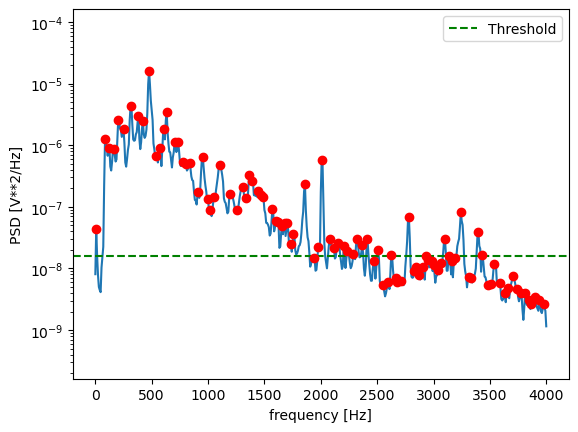

Filtered peak frequencies:  [   7.8125   85.9375  125.      164.0625  203.125   250.      312.5
  382.8125  421.875   476.5625  539.0625  570.3125  609.375   632.8125
  703.125   734.375   773.4375  804.6875  835.9375  914.0625  953.125
 1000.     1015.625  1054.6875 1101.5625 1195.3125 1257.8125 1312.5
 1335.9375 1367.1875 1390.625  1445.3125 1468.75   1484.375  1570.3125
 1601.5625 1617.1875 1656.25   1679.6875 1703.125  1734.375  1757.8125
 1859.375  1976.5625 2007.8125 2078.125  2117.1875 2156.25   2203.125
 2234.375  2289.0625 2320.3125 2367.1875 2414.0625 2507.8125 2625.
 2781.25   3101.5625 3242.1875 3398.4375 3429.6875]


In [12]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

filtered_peak_freqs = extract_peak_frequencies(X_pretrain.flatten(), sampling_rate, threshold=1e-3, nperseg=1024, visualize=True)

## Applying normal band pass filter on data

In [13]:
X_pretrain_band, X_train_band, X_test_band = generate_multivariate_dataset(filtered_peak_freqs, X_pretrain, X_train, X_test, sampling_rate, nb_jobs=-1, visualize=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1421 out of 1500 | elapsed:    6.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.0s finished


## Standardizing the amplitudes

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
filtered_data = scaler.fit_transform(X_pretrain_band)

In [15]:
# train
X_train_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_train_band]

In [16]:
# test
X_test_band = [np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in x]) for x in X_test_band]

In [17]:
X_train_band[0].shape

(61, 3448)

# Generating reservoirs

## Plot  pretrain dataset

In [18]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/filtered_peak_freqs[-1]

min_window_size

2.3325740318906605

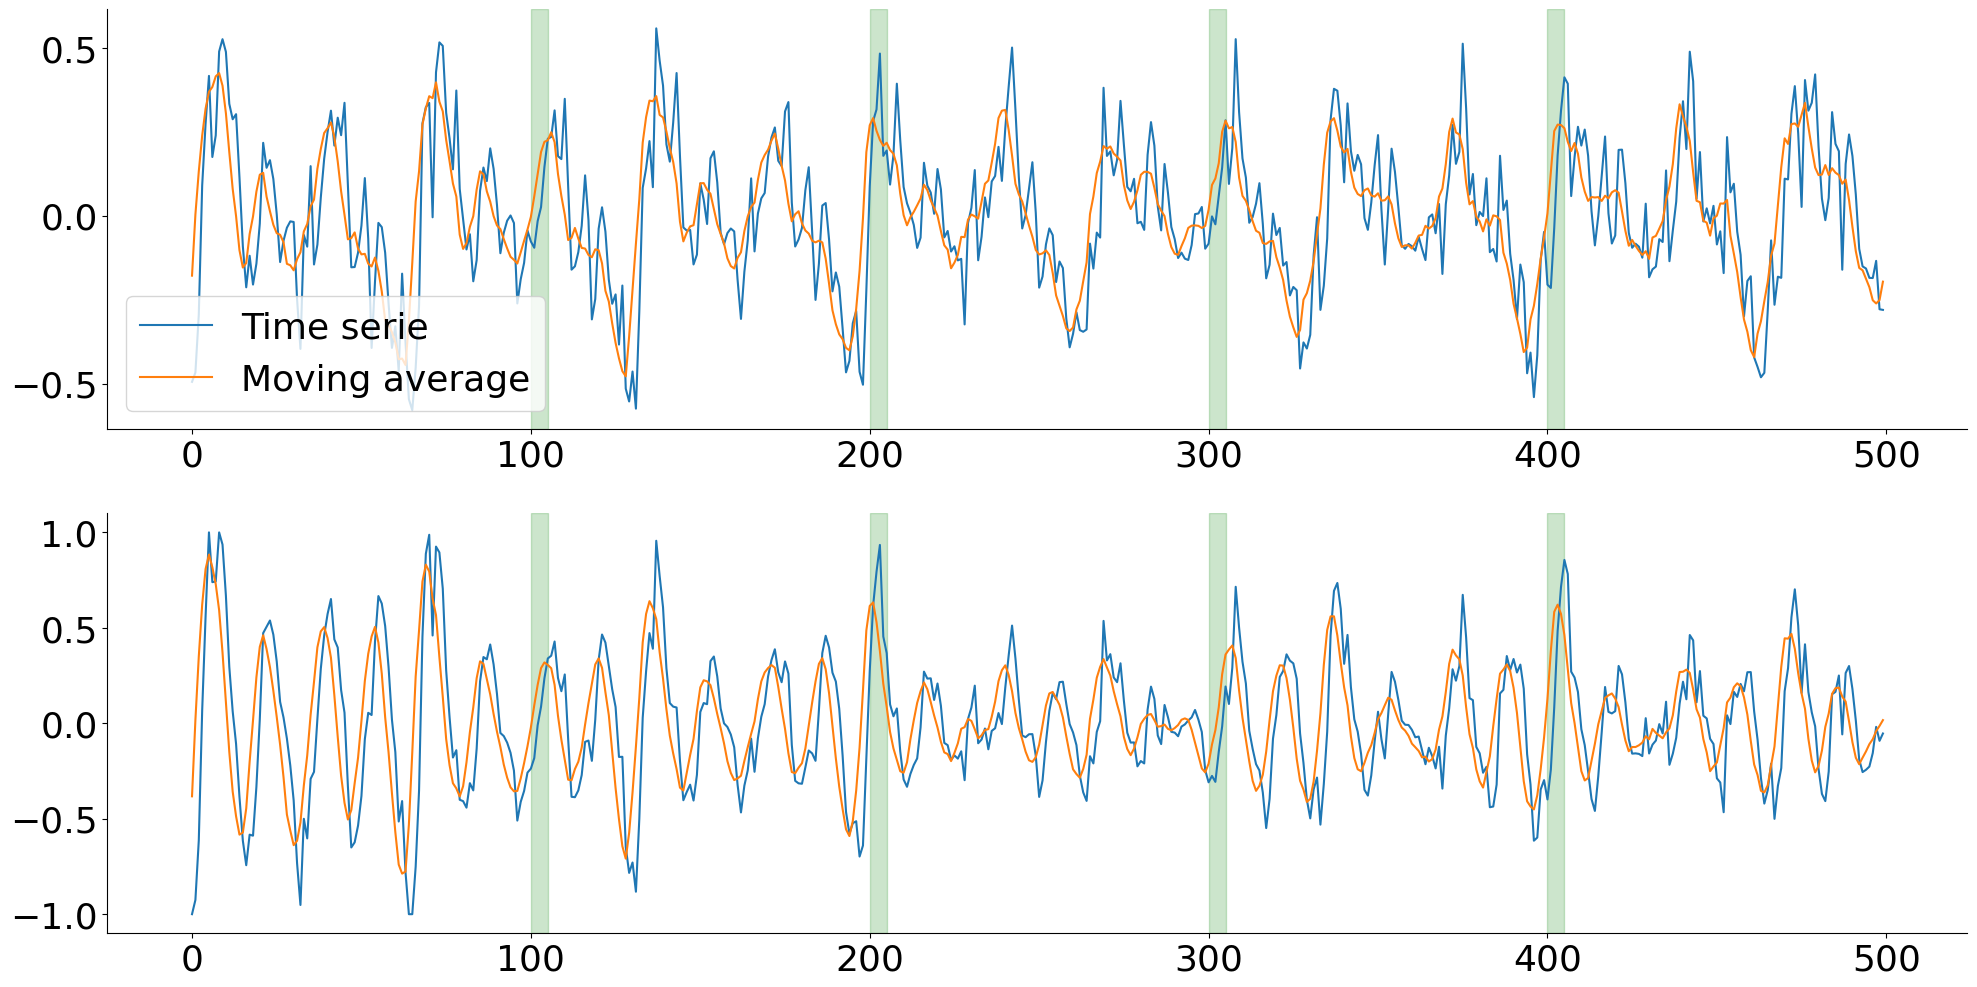

In [19]:
#Compute the moving average 
window_size = 5
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

#CPlot the two for different frequencies
NB_1 = 3
fig, ax = plt.subplots(2, 1, figsize=(24,12))
ax[0].plot(range(500), filtered_data[NB_1, 1000:1500], label='Time serie')
ax[0].plot(range(500), ma[NB_1, 1000:1500], label='Moving average')
NB_2 = 10
ax[0].legend(fontsize=26)
ax[1].plot(range(500), filtered_data[NB_2, 1000:1500], label='Time serie')
ax[1].plot(range(500), ma[NB_2, 1000:1500], label='Moving average')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', labelsize=26)
ax[1].tick_params(axis='both', labelsize=26)


# draw vertical lines to represent the window for some points
for x in range(100, 500, 100):
    ax[0].axvspan(x, x+window_size, color='g', alpha=0.2)
for x in range(100, 500, 100):
    ax[1].axvspan(x, x+window_size, color='g', alpha=0.2)

plt.show()

## Construct matrices

### Shared parameters

In [20]:
import math 

# We want the size of the reservoir to be at least 200
K = math.ceil(200 / filtered_peak_freqs.shape[0])
n = filtered_peak_freqs.shape[0] * K
n

244

In [25]:
INCREMENT = 5
VALUE = 0.05
target_rate = 0.7
growth_parameter = 0.15

bias_scaling = 1
input_scaling = 0.15
leaky_rate = 1

In [26]:
import reservoir.reservoir
from reservoir.reservoir import update_reservoir
from reservoir.reservoir import init_matrices
from connexion_generation.utility import compute_synaptic_change
from connexion_generation.bounded_adsp import bounded_adsp

class TwoDimArrayWrapper:
    def __init__(self, input_data):
        if input_data.ndim != 2:
            raise ValueError("Expected a 2D array.")
        self.input_data = input_data
        self.shape = input_data.shape
        self.size = input_data.shape[1]
        self.flat_data = input_data.flatten()

    def __getitem__(self, key):
        # Handle single element access
        return self.input_data[:, key]

def run_HADSP_algorithm(W, Win, bias, input_data, visualize=False):
    # last_state
    state = np.random.uniform(0, 1, n)
    state_history = []
    
    total_add = 0
    total_prun = 0
    add = []
    prun = []
    step=0

    for i in range(INCREMENT*5):
        state = update_reservoir(W, Win, input_data[i], state, leaky_rate, bias, activation_function)
        state_history.append(state)

    # size of simulation 
    number_steps = int((input_data.size-INCREMENT*5)/INCREMENT)
    for k in tqdm(range(number_steps)): 
        delta_z = compute_synaptic_change(state_history[-INCREMENT:], target_rate, growth_parameter, average="WHOLE")
        W, _, nb_new_add, nb_new_prun = bounded_adsp(W, state, delta_z, VALUE)
    
        for i in range(INCREMENT):
            state = update_reservoir(W, Win, input_data[INCREMENT*(k+5)+i], state, leaky_rate, bias, activation_function)
            state_history.append(state)
            
        total_add += nb_new_add
        total_prun += nb_new_prun
        add.append(total_add)
        prun.append(total_prun)
        step += 1
        
    add = np.array(add)
    prun = np.array(prun)

    if visualize:
        plt.figure()
        plt.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
        plt.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
        plt.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
        plt.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
        plt.legend()
        plt.grid()
    return W

def initialise_and_train(input_scaling, n, bias_scaling, seed, training_set, visualize=False):
    Win, W, bias = init_matrices(n, 1, 0, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling
    
    W = run_HADSP_algorithm(W, Win, bias, training_set, visualize=visualize)

    connectivity =  W.count_nonzero() / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = max(abs(eigen))
    
    return Win, W, bias, connectivity, sr


In [27]:
frequency_bands = np.repeat(filtered_data, K, axis=0)
     
frequency_bands = TwoDimArrayWrapper(frequency_bands)
frequency_bands.shape

(244, 63640)

In [28]:
# HADSP + multi
Win_hasp_band, W_hasp_band, bias_hasp_band, connectivity_band, sr_adsp = initialise_and_train(input_scaling, n, bias_scaling, SEED, frequency_bands)

# 3rd (random + multi)
Win_3, W_3, bias_3 =  init_matrices(n, 1, connectivity_band, sr_adsp)
bias_3= bias_3*bias_scaling
Win_3= Win_3*input_scaling

eigen_3 = sparse.linalg.eigs(W_3, k=1, which="LM", maxiter=W_3.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_3 = max(abs(eigen_3))
    

100%|██████████| 12723/12723 [01:07<00:00, 188.80it/s]


<Axes: >

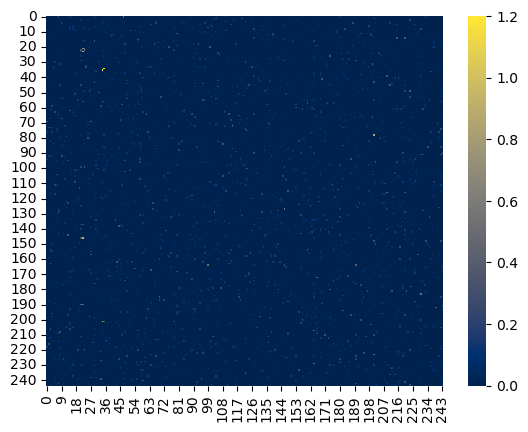

In [29]:
heatmap(W_hasp_band.todense(), cmap=color_palette("cividis", as_cmap=True))

### Univariate matrices

In [30]:
# HADSP + uni
Win_hadsp_uni, W_hadsp_uni, bias_hadsp_uni, connectivity_hadsp_uni, sr_hadsp_uni = initialise_and_train(input_scaling, n, bias_scaling, SEED, X_pretrain.flatten())

# random + uni
Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_hadsp_uni)
bias_normal= bias_normal*bias_scaling
Win_normal= Win_normal*input_scaling   

eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_normal = max(abs(eigen_normal))


100%|██████████| 12723/12723 [00:10<00:00, 1179.89it/s]


<Axes: >

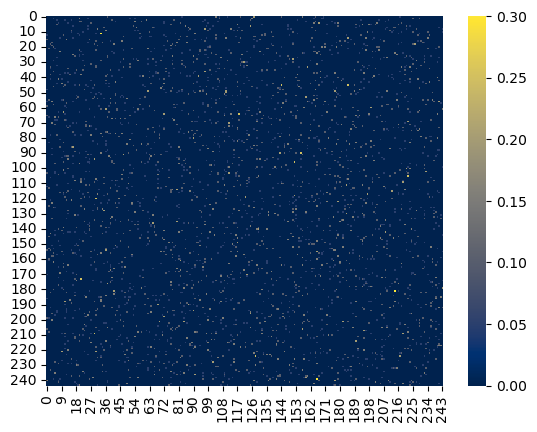

In [31]:
heatmap(W_hadsp_uni.todense(), cmap=color_palette("cividis", as_cmap=True))

## Spectral radius normalisation

In [32]:
print(sr_normal)
print(sr_hadsp_uni)
print(sr_3)
print(sr_adsp)

1.0000000007942704
1.0243737088893858
1.2341655681919321
1.234165556444263


In [33]:
# Spectral radius normalisation
normal_sr = 0.99
W_normal = W_normal/sr_normal*normal_sr
W_hadsp_uni = W_hadsp_uni/sr_hadsp_uni*normal_sr
W_3 = W_3/sr_3*normal_sr
W_hasp_band = W_hasp_band/sr_adsp*normal_sr

# Performance

In [34]:
from reservoirpy.nodes import Reservoir, Ridge, Input, ESN
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score

N_JOBS = -1

def train_and_predict_model(W, Win, bias, activation_function, ridge_coef, compute_data, predict_data):
    # To remember : 
    #  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias
    
    reservoir = Reservoir(units=n, 
                          W =csr_matrix(W), 
                          Win=csr_matrix(np.diag(Win.toarray().flatten())), 
                          bias=csr_matrix(bias).T, 
                          activation=activation_function,
                          equation='external'
                         )
    readout = Ridge(ridge=ridge_coef)
    model = ESN(reservoir=reservoir, readout=readout)
    
    states_train = []

    def compute_state(x):
        return reservoir.run(x, reset=True)[-1, np.newaxis].flatten()
    
    states_train = Parallel(n_jobs=N_JOBS)(delayed(compute_state)(x) for x in compute_data)

    readout.fit(np.array(states_train), Y_train)

    Y_pred = []
    def predict(x):
        states = reservoir.run(x, reset=True)
        y = readout.run(states[-1, np.newaxis])
        return y

    Y_pred = Parallel(n_jobs=N_JOBS)(delayed(predict)(x) for x in predict_data)

    return Y_pred


def compute_score(Y_pred, Y_test, model_name):
    Y_pred_class = [np.argmax(y_p) for y_p in Y_pred]
    Y_test_class = [np.argmax(y_t) for y_t in Y_test]

    score = accuracy_score(Y_test_class, Y_pred_class)

    print(f"Accuracy for {model_name}: {score * 100:.3f} %")
    return score
    

## Classification for multivariate

In [35]:
# We want the size of the reservoir to be at least 200
caca = []
caca_test = []
for i in tqdm(range(len(X_train_band))):
    #caca.append(np.repeat(X_train[i], K, axis=1))
    caca.append(np.repeat(X_train_band[i], K, axis=0).T) # axis still depend of X_train shape
for i in tqdm(range(len(X_test_band))):
    #caca_test.append(np.repeat(X_test[i], K, axis=1))
    caca_test.append(np.repeat(X_test_band[i], K, axis=0).T)

100%|██████████| 1500/1500 [00:04<00:00, 310.89it/s]


In [36]:
ridge_coef = 1e-8

# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias
Y_pred_hasp_band = train_and_predict_model(W_hasp_band, Win_hasp_band, bias_hasp_band, activation_function, ridge_coef, caca, caca_test)

Y_pred_3 = train_and_predict_model(W_3, Win_3, bias_3, activation_function, ridge_coef, caca, caca_test)


In [37]:
score = compute_score(Y_pred_hasp_band, Y_test, "HADSP multi")

score = compute_score(Y_pred_3, Y_test, "random multi")

Accuracy for HADSP multi: 18.267 %
Accuracy for random multi: 17.467 %


## Classification for univariate

In [38]:
# Create a list to store the arrays

pipi = []
pipi_test = []

for i in range(len(X_train)):
    pipi.append(np.repeat(X_train[i], n, axis=1))
    #pipi.append(np.repeat(X_train[i], n, axis=0).T) # axis still depend of X_train shape
    
for i in range(len(X_test)):
    pipi_test.append(np.repeat(X_test[i], n, axis=1))
    #pipi_test.append(np.repeat(X_test[i], n, axis=0).T)
    
pipi[0].shape

(3448, 244)

In [39]:
Y_pred_hadsp_uni = train_and_predict_model(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, activation_function, ridge_coef, pipi, pipi_test)

Y_pred_normal = train_and_predict_model(W_normal, Win_normal, bias_normal, activation_function, ridge_coef, pipi, pipi_test)

In [40]:
score = compute_score(Y_pred_hadsp_uni, Y_test, "HADSP uni")

score = compute_score(Y_pred_normal, Y_test, "random uni")

Accuracy for HADSP uni: 10.533 %
Accuracy for random uni: 10.533 %


## Prediction ahead

### Training

In [ ]:
import reservoir.reservoir
from reservoir.reservoir import train_ei, train
reload(reservoir.reservoir)

ridge_coef = 1e-7
step_ahead = 30

# To remember
np.zeros(2000)

print(frequency_bands.shape)
print(input_data.shape)
# to generate the evaluation dataset
START_EVAL_STEP = 3000
x_train_bands = frequency_bands[:,:START_EVAL_STEP]
x_train_normal = input_data[:START_EVAL_STEP]
y_train = input_data[step_ahead:START_EVAL_STEP+step_ahead]

# Training random + MG
Wout_normal, b_out_normal, last_state_normal = train(W_normal, Win_normal, bias_normal, x_train_normal, y_train, activation_function, ridge_coef = ridge_coef)

# Training for HADSP + MG
Wout_hadsp_multi, b_out_hadsp_multi, last_state_hadsp_multi = train(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, x_train_normal, y_train, activation_function, ridge_coef = ridge_coef)

# Training random + bandfilter
Wout_3, b_out_3, last_state_3 = train(W_3, Win_3, bias_3, x_train_bands, y_train, activation_function, ridge_coef = ridge_coef)

# Training output HASDP + bandfilter
Wout_hasp_band, b_out_hasp_band, last_state_hasp_band = train(W_hasp_band, Win_hasp_band, bias_hasp_band, x_train_bands, y_train, activation_function, ridge_coef = ridge_coef)

### Prediction

In [ ]:
from reservoir.reservoir import run
reload(reservoir.reservoir)
from reservoir.reservoirpy_util import plot_results, plot_readout


ending_eval_step = 4900
x_eval_bands = frequency_bands[:,START_EVAL_STEP:ending_eval_step]
x_eval_normal = input_data[START_EVAL_STEP:ending_eval_step]
y_target = input_data[START_EVAL_STEP + step_ahead :ending_eval_step + step_ahead]

# Prediction for random + MG
y_pred_normal = run(W_normal, Win_normal, bias_normal, Wout_normal, x_eval_normal, activation_function, b_out_normal, last_state_normal)

# Prediction for HADSP + MG
y_pred_hadsp_multi = run(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, Wout_hadsp_multi, x_eval_normal, activation_function, b_out_hadsp_multi, last_state_hadsp_multi)

# Prediction for random + bandfilter
y_pred_3 = run(W_3, Win_3, bias_3, Wout_3, x_eval_bands, activation_function, b_out_3, last_state_3)

# Prediction for HADSP + bandfilter
y_pred_hasp_band = run(W_hasp_band, Win_hasp_band, bias_hasp_band, Wout_hasp_band, x_eval_bands, activation_function, b_out_hasp_band, last_state_hasp_band)


plot_results(y_pred_3, y_target, sample=400)

In [ ]:
import reservoir.losses
from reservoir.losses import rmse, nrmse
reload(reservoir.losses)

print("nrmse normal        :", float(nrmse(y_target[:300], y_pred_normal[:300])))
print("nrmse hadsp     :", float(nrmse(y_target[:300], y_pred_hadsp_multi[:300])))
print("nrmse random + band :", float(nrmse(y_target[:300], y_pred_3[:300])))
print("nrmse hadsp + band   :", float(nrmse(y_target[:300], y_pred_hasp_band[:300])))

In [ ]:
y_pred_hadsp_multi.shape

In [ ]:
nrmse_array_normal = []
nrmse_array_hadsp_multi = []
nrmse_array_3 = []
nrmse_array_mg = []

for i in range(len(y_target)-100- step_ahead):
    y_target_i = y_target[i:100+i]
    nrmse_array_normal.append(nrmse(y_target_i, y_pred_normal[i:100+i]))
    nrmse_array_hadsp_multi.append(nrmse(y_target_i, y_pred_hadsp_multi[i:100+i]))
    nrmse_array_3.append(nrmse(y_target_i, y_pred_3[i:100+i]))
    nrmse_array_mg.append(nrmse(y_target_i, y_pred_hasp_band[i:100+i]))
    
log10_nrmse_normal = np.log10(nrmse_array_normal)
log10_nrmse_hadsp_multi = np.log10(nrmse_array_hadsp_multi)
log10_nrmse_3 = np.log10(nrmse_array_3)
log10_nrmse_mg = np.log10(nrmse_array_mg)
plt.figure()
plt.plot(log10_nrmse_normal[:1000])
plt.plot(log10_nrmse_hadsp_multi[:1000])
plt.plot(log10_nrmse_3[:1000])
plt.plot(log10_nrmse_mg[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["HADSP+band", "random", " random + bandfilter", "HADSP"])
plt.show()

# Analysis

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from collections import defaultdict
from scipy.sparse import coo_matrix

def plot_connectivity(coo):
    G = nx.DiGraph()

    # Convert coo_matrix to edge list and add edges to the graph
    for node1, node2 in zip(coo.row, coo.col):
        G.add_edge(node1, node2)

    triad_connections = defaultdict(int)

    # Get all sets of 3 nodes
    for nodes in combinations(G.nodes, 3):
        # For each node in the triad, count its incoming and outgoing connections within the triad
        connectivity_states = []
        for node in nodes:
            in_edges = sum([G.has_edge(other, node) for other in nodes if other != node])
            out_edges = sum([G.has_edge(node, other) for other in nodes if other != node])
            connectivity_states.append((in_edges, out_edges))
        # Sort the connectivity states so that equivalent triads have the same key, regardless of node order
        connectivity_states = tuple(sorted(connectivity_states))
        triad_connections[connectivity_states] += 1

    # Sort results by total number of connections
    sorted_results = sorted(((sum(in_edges for in_edges, out_edges in key) + sum(out_edges for in_edges, out_edges in key), key) for key in triad_connections.items()), key=lambda x: x[0])
    sorted_labels = [str(key) for total, key in sorted_results]
    sorted_values = [triad_connections[key] for total, key in sorted_results]

    # Plot results
    plt.bar(range(len(sorted_labels)), sorted_values, tick_label=sorted_labels)
    plt.xlabel('Triad connectivity state')
    plt.ylabel('Count')
    plt.title('Triad Connection Count in Graph')
    plt.xticks(rotation=90)
    plt.show()


plot_connectivity(W_normal)

In [ ]:
plot_connectivity(W_hasp_band)

In [ ]:
time_series = filtered_data
# Create a matrix to hold the mutual information between each pair of time series
mi_matrix = np.zeros((len(time_series), len(time_series)))

    
# Function to compute mutual information
def compute_mi(i, j):
    # Discretize the data
    time_series_i_discrete = np.floor(time_series[i] * 10).astype(int)
    time_series_j_discrete = np.floor(time_series[j] * 10).astype(int)
    
    # Compute mutual information
    mi = mutual_info_score(time_series_i_discrete, time_series_j_discrete)
    
    return i, j, mi

# Create a list of all pairs of indices
indices = [(i, j) for i in range(len(time_series)) for j in range(i, len(time_series))]



# Use joblib to parallelize the computation
results = Parallel(n_jobs=-1, backend="threading", verbose=1)(delayed(compute_mi)(i, j) for i, j in indices)

# Store the results in the matrix
for i, j, mi in results:
    mi_matrix[i, j] = mi
    mi_matrix[j, i] = mi

pbar.close()

heatmap(mi_matrix)